# Libraries

In [1]:
# for working with data
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Set2")

# for collecting data
import yfinance as yf

# for preprocessing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler

# for modelling
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout, LSTM

# for evaluation
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# for others
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Implementation

In [2]:
def collect_data(tickers="AAPL", start="2019-1-1", end="2024-4-15", saved_path=None, interval="1d"):
    data = yf.download(tickers=tickers, start=start, end=end, interval=interval, progress=False)
    if saved_path is not None:
        data.to_csv(f"{saved_path}.csv")
    else:   
        return data

def load_data(filename, date_column="Date"):
    data = pd.read_csv(filename)
    data[date_column] = pd.to_datetime(data[date_column])
    data = data.set_index(date_column)
    return data

In [3]:
def create_shiftback_dataset(raw, shift_back=3, start=None, end=None):
    columns = [f"lag_{i}" for i in range(shift_back, 0, -1)]
    data = pd.DataFrame([], columns=["Date"] + columns + ["Target"])
    raw = raw.loc[:end:]
    for i in range(shift_back, raw.shape[0]):
        values = [raw.iloc[i-shift] for shift in range(shift_back, -1, -1)]
        values = [raw.index[i]] + values
        data.loc[len(data.index)] = values
    
    data = data.set_index("Date")
    # data = data[list(data.columns[1:]) + ["Target"]]
    return data[start::]

In [4]:
def check_stationary_adf(data, significance_level=0.05, boolen_output=False, quiet=False):
    dftest = adfuller(data)
    p_value = dftest[1]
    stationary = p_value < significance_level
    if not quiet:
        print(f"p_value: {p_value}")
        if stationary:
            print("Data is stationary")
        else:
            print("Data is non-stationary")

    if boolen_output:
        return p_value < significance_level

In [5]:
def differencing(data, order=1):
    new_data = data.copy()
    while order > 0:
        new_data = new_data.diff().dropna()
        order -= 1
    return new_data

def diff_order(data, significance_level=0.05):
    order = 0
    data_diff = data.copy()
    while not check_stationary_adf(data_diff, significance_level, boolen_output=True, quiet=True):
        order += 1
        data_diff = data_diff.diff().dropna()
    return order

In [6]:
def acf_pacf(data, figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2, sharey=True)

    plot_acf(data, ax=ax[0])
    plot_pacf(data, ax=ax[1])
    ax[0].set_ylim(top=1.15)
    plt.show()

# Load Data

In [7]:
try:
    data_org = load_data("data/dataset/AAPL_train.csv")
except:
    collect_data(saved_path="data/dataset/AAPL")
    data_org = load_data("data/dataset/AAPL_train.csv")

In [8]:
data = data_org[["Adj Close"]].copy()

# Data Exploration

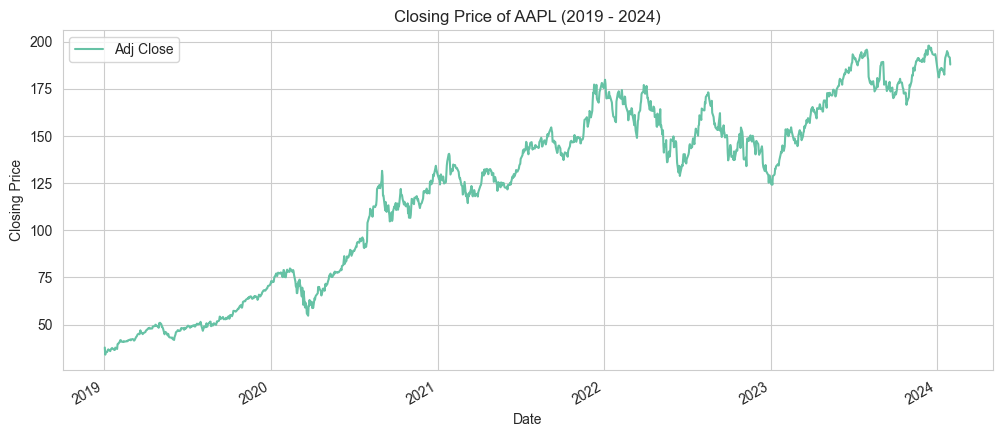

In [9]:
data.plot(figsize=(12, 5), title="Closing Price of AAPL (2019 - 2024)", ylabel="Closing Price")
plt.show()

__COMMENTS__
* upward trend
* non-stationary

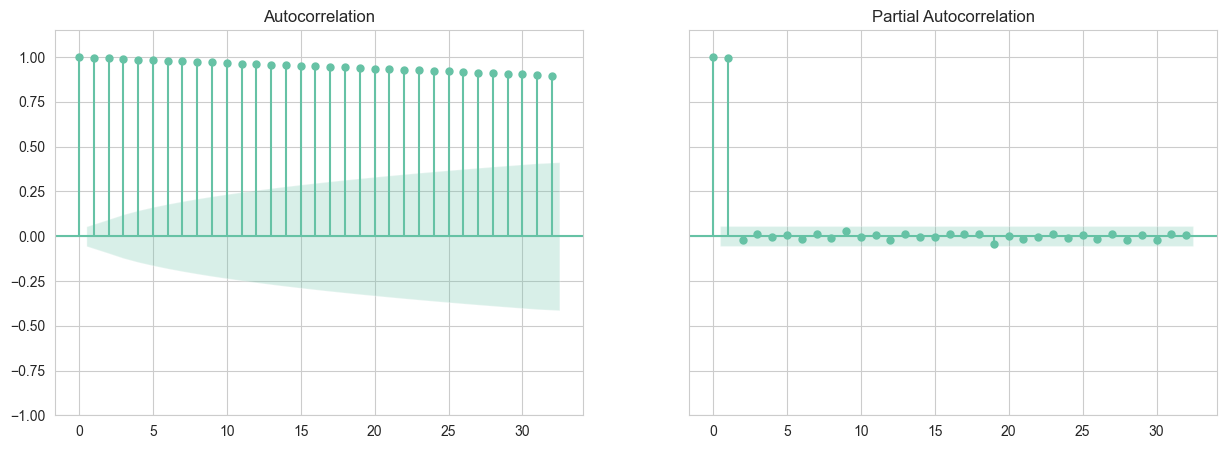

In [10]:
acf_pacf(data)

In [11]:
check_stationary_adf(data, significance_level=0.01)

p_value: 0.646812275201447
Data is non-stationary


# Differencing

In [12]:
print(f"Differencing order: {diff_order(data, significance_level=0.01)}")

Differencing order: 1


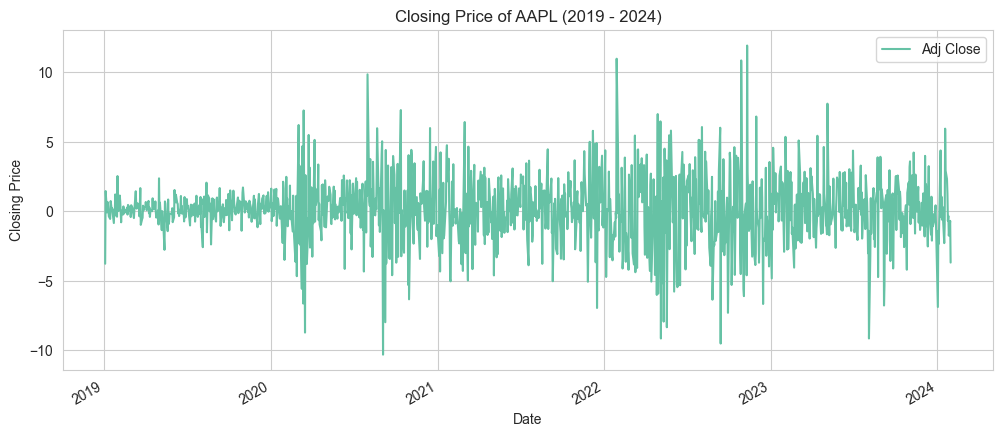

In [13]:
differencing(data, order=1).plot(figsize=(12, 5), title="Closing Price of AAPL (2019 - 2024)", ylabel="Closing Price")
plt.show()

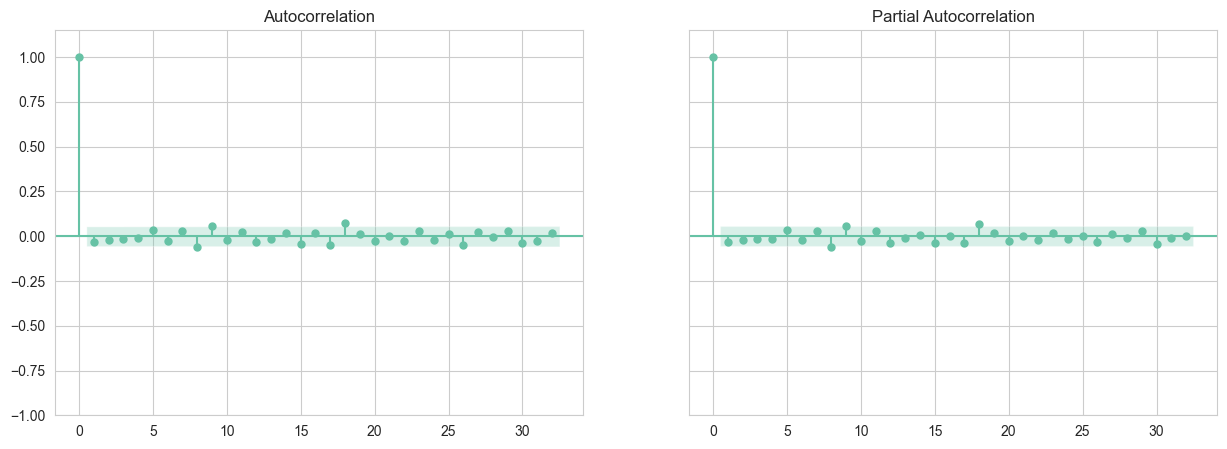

In [14]:
acf_pacf(differencing(data, order=1))

__COMMENTS__
* Data after the first differencing seems to be White Noise

# Modelling

In [15]:
result = {"model": [],
          "RMSE": [],
          "MAPE": []}

## ARIMA

__Using Data From 01.2019 To 01.2024 To Predict Stock Price From 02.2024 to 04.2024__

In [16]:
train = load_data(filename=r"data\dataset\AAPL_train.csv")
test = load_data(filename=r"data\dataset\AAPL_test.csv")

In [17]:
def optimise_ARIMA(data, order_list=None, p=range(0, 6), d=range(0, 3), q=range(0, 6), summary_output=True):
    """
    Optimise ARIMA model
    
    :param order_list: list with (p, d, q) tuples
    :param exog: the exogenous variable

    :return: dataframe with parameters and corresponding AIC 
    """
    results = []
    
    if order_list is None:
        order_list = list(product(p, d, q))

    for order in tqdm(order_list):
        model = ARIMA(order=order, suppress_warnings=True).fit(data)
        results.append([order, model.aic()])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    if summary_output:
        return result_df.iloc[0, 0], result_df
    return result_df.iloc[0, 0]

In [18]:
run = False
if run:
    best_order, summary_finding = optimise_ARIMA(data["Adj Close"])
    print(f"Best order for ARIMA: {best_order}")
    summary_finding

__Using Data From 01.2019 To 01.2024 To Predict For The Next Period From 02.2024 To 04.2024__

In [19]:
best_arima = auto_arima(train["Adj Close"], start_p=0, start_q=0,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q
                        d=None,           # let model determine 'd'
                        seasonal=True,   # No Seasonality
                        trace=True,
                        suppress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5829.240, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5829.671, Time=0.12 sec


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5829.599, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5830.378, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5830.836, Time=0.58 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.220 seconds


In [20]:
order = best_arima.order
model = ARIMA(train["Adj Close"], order=best_arima.order)
model_fit = model.fit()

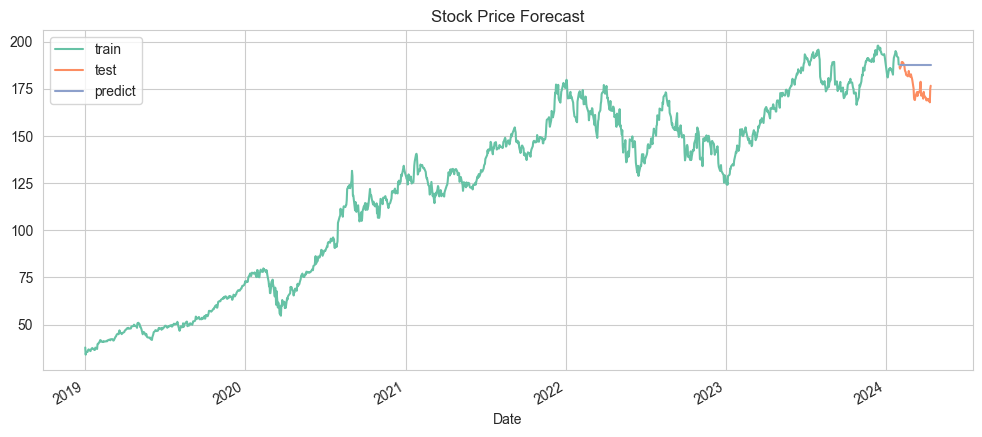

In [21]:
ax = train["Adj Close"].plot(figsize=(12, 5), label="train", title="Stock Price Forecast")
y_pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
y_pred = pd.DataFrame(y_pred.values, index=list(test.index), columns=["predict"])
test["Adj Close"].plot(ax=ax, label="test")
y_pred.plot(ax=ax, label="predict")
plt.legend()

In [22]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1278
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2914.189
Date:                Wed, 01 May 2024   AIC                           5830.378
Time:                        17:35:28   BIC                           5835.530
Sample:                             0   HQIC                          5832.312
                               - 1278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.6195      0.147     38.200      0.000       5.331       5.908
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):               361.61
Prob(Q):                              0.21   Pr

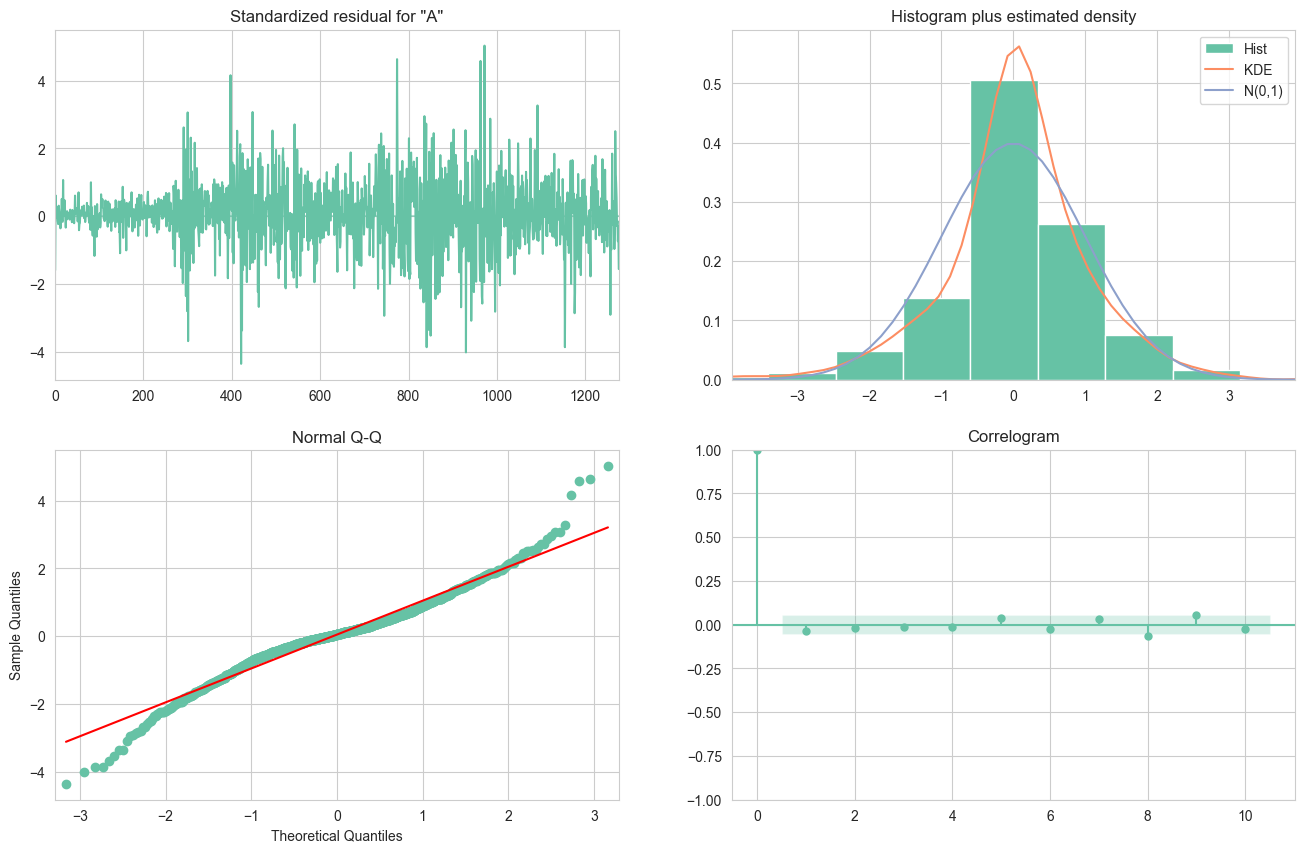

In [23]:
model_fit.plot_diagnostics(figsize=(16, 10))
plt.show()

In [24]:
print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Adj Close"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Adj Close"]))

RMSE: 12.774228677136971
MAPE: 0.0631606621140656


__Daily Forecasts - Data Updated After Each Day__

In [25]:
best_arima = auto_arima(train["Adj Close"], start_p=0, start_q=0,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q
                        d=None,           # let model determine 'd'
                        seasonal=True,   # No Seasonality
                        trace=False,
                        suppress_warnings=True,
                        stepwise=True)

order = best_arima.order
y_pred = []
model = ARIMA(train["Adj Close"].values, order=order)
model_fit = model.fit()
for i in range(-1, test.shape[0]-1, 1):
    if i > -1:
        model_fit = model_fit.append(test.iloc[i:i+1, -2].values)
    y_pred.append(model_fit.forecast(1))
y_pred = pd.DataFrame(y_pred, index=test.index, columns=["Predict"])

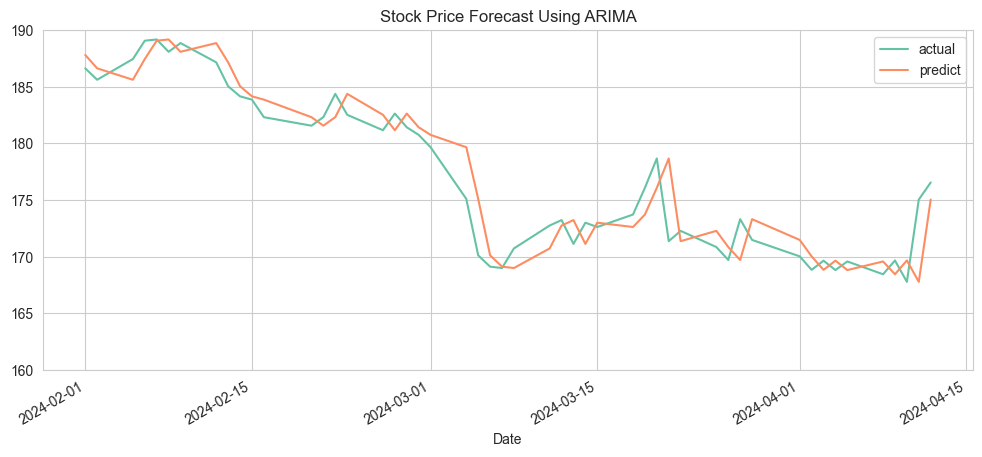

In [26]:
ax = test["Adj Close"].plot(figsize=(12, 5), label="actual", title="Stock Price Forecast Using ARIMA")
y_pred["Predict"].plot(ax=ax, label="predict")
ax.set_ylim(top=190, bottom=160)
plt.legend()
plt.show()

In [27]:
print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Adj Close"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Adj Close"]))

RMSE: 2.247846655924602
MAPE: 0.009657146383194442


In [28]:
result["model"].append("ARIMA")
result["RMSE"].append(RMSE(y_pred=y_pred, y_true=test["Adj Close"]))
result["MAPE"].append(MAPE(y_pred=y_pred, y_true=test["Adj Close"]))

## FBProphet

__Using Data From 01.2019 To 01.2024 To Predict Stock Price From 02.2024 to 04.2024__

In [29]:
data = load_data(r"data\dataset\AAPL.csv")
train = data.loc["2019-1-1":"2024-1-31", "Adj Close"]
test = data.loc["2024-2-1":, "Adj Close"]
combine = pd.concat([train, test], axis=0)

In [30]:
model = Prophet()
model.fit(train.reset_index().rename(columns={"Date": "ds", "Adj Close": "y"}))

17:35:31 - cmdstanpy - INFO - Chain [1] start processing
17:35:31 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
pred_dates = combine.reset_index().rename(columns={"Date": "ds"})[["ds"]]
forecast = model.predict(pred_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-02,38.249911,29.251789,47.687378
1,2019-01-03,38.008724,29.359868,47.835395
2,2019-01-04,37.766129,28.904247,47.088304
3,2019-01-07,37.483269,28.478699,46.994981
4,2019-01-08,37.101693,27.575659,46.619344


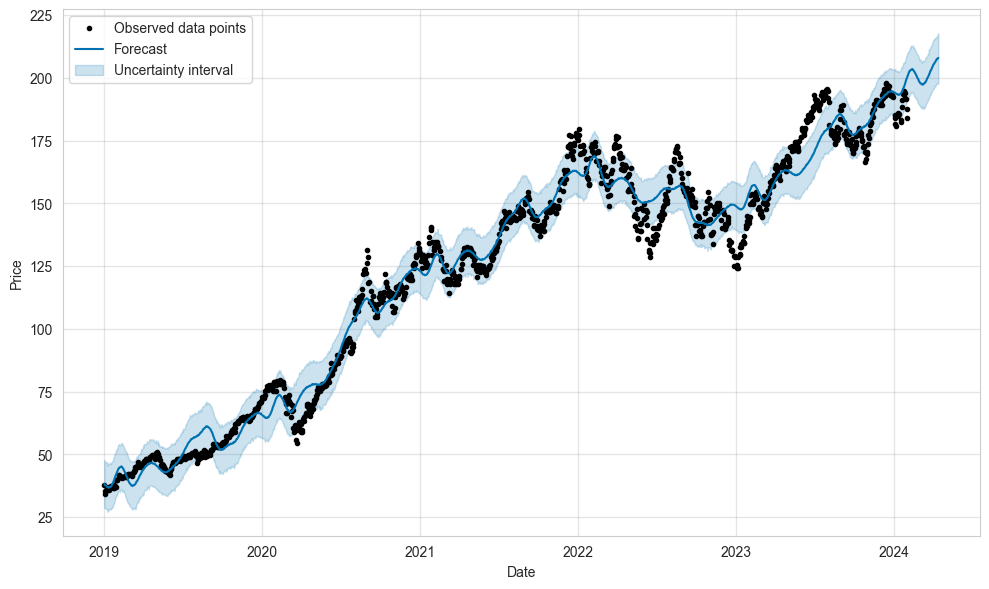

In [43]:
model.plot(forecast, include_legend=True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

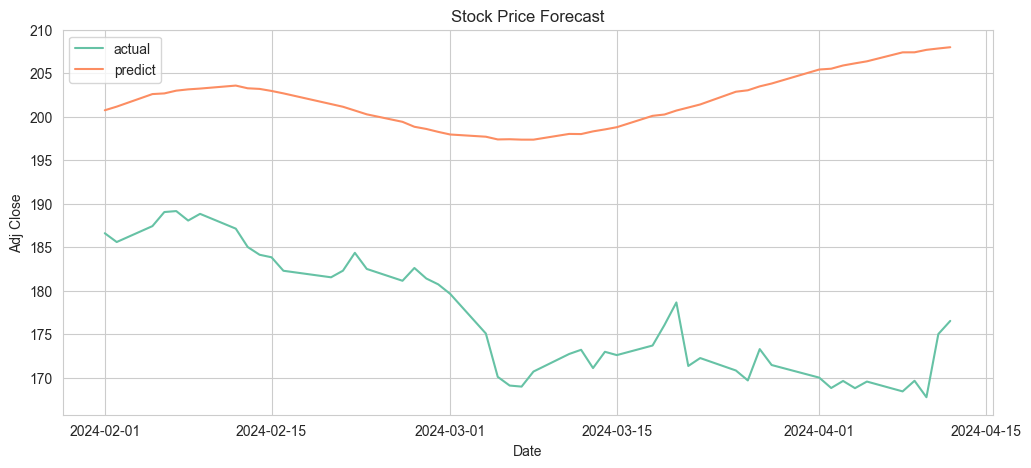

In [40]:
pred_dates = test.reset_index().rename(columns={"Date": "ds"})[["ds"]]
forecast = model.predict(pred_dates)

plt.figure(figsize=(12, 5))
sns.lineplot(label="actual", x=test.index, y=test)
# test["Adj Close"].plot(ax=ax, label="test")
sns.lineplot(x=test.index, y=forecast["yhat"], label="predict")
plt.title("Stock Price Forecast")
plt.legend()

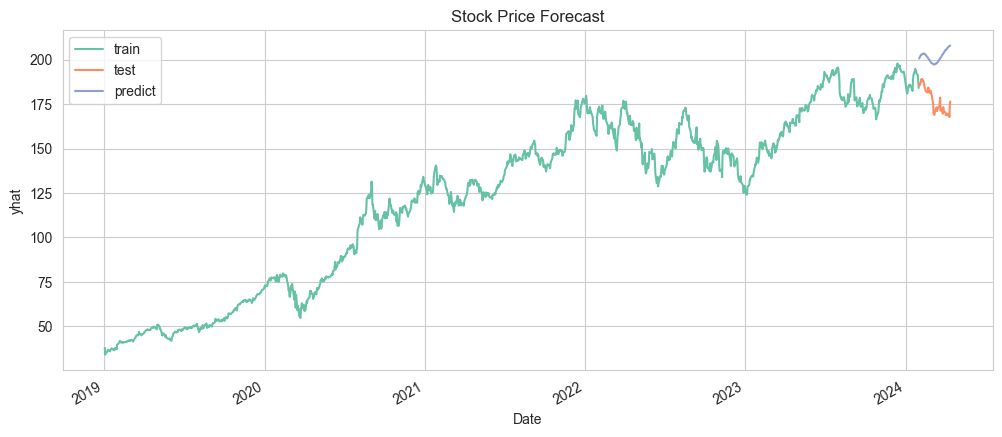

In [44]:
ax = train.plot(figsize=(12, 5), label="train", title="Stock Price Forecast")
test.plot(ax=ax, label="test")
sns.lineplot(ax=ax, x=test.index, y=forecast['yhat'], label="predict")
plt.legend()

In [34]:
print("RMSE:", RMSE(y_pred=forecast['yhat'], y_true=test))
print("MAPE:", MAPE(y_pred=forecast['yhat'], y_true=test))

RMSE: 26.022202213490058
MAPE: 0.14189702653811812


__Daily Forecasts - Data Updated After Each Day__

In [35]:
data = load_data(r"data\dataset\AAPL.csv")
train = data.loc["2019-1-1":"2024-1-31", "Adj Close"]
test = data.loc["2024-2-1":, "Adj Close"]
train = train.reset_index().rename(columns={"Date": "ds", "Adj Close": "y"})
test = test.reset_index().rename(columns={"Date": "ds", "Adj Close": "y"})

In [36]:
pd.concat([train, test.iloc[0:1]], ignore_index=True)

,ds,y
0,2019-01-02,37.845039
1,2019-01-03,34.075397
2,2019-01-04,35.530052
3,2019-01-07,35.450966
4,2019-01-08,36.126770
...,...,...
1275,2024-01-26,192.174774
1276,2024-01-29,191.485657
1277,2024-01-30,187.800354
1278,2024-01-31,184.164993


In [37]:
y_pred = pd.DataFrame({"ds": [],
                       "yhat": []})
for i in range(-1, test.shape[0]-1, 1):
    if i == -1:
        train_fit = train
    else:
        train_fit = pd.concat([train_fit, test.iloc[i:i+1]], ignore_index=True)
    model = Prophet()
    model.fit(train_fit)
    test_fit = test.iloc[i+1:i+2, 0:1]
    predict = model.predict(test_fit)[['ds', 'yhat']]
    y_pred = pd.concat([y_pred, predict], ignore_index=True)

16:54:09 - cmdstanpy - INFO - Chain [1] start processing


16:54:09 - cmdstanpy - INFO - Chain [1] done processing
16:54:10 - cmdstanpy - INFO - Chain [1] start processing
16:54:10 - cmdstanpy - INFO - Chain [1] done processing
16:54:11 - cmdstanpy - INFO - Chain [1] start processing
16:54:11 - cmdstanpy - INFO - Chain [1] done processing
16:54:11 - cmdstanpy - INFO - Chain [1] start processing
16:54:12 - cmdstanpy - INFO - Chain [1] done processing
16:54:12 - cmdstanpy - INFO - Chain [1] start processing
16:54:13 - cmdstanpy - INFO - Chain [1] done processing
16:54:13 - cmdstanpy - INFO - Chain [1] start processing
16:54:14 - cmdstanpy - INFO - Chain [1] done processing
16:54:14 - cmdstanpy - INFO - Chain [1] start processing
16:54:15 - cmdstanpy - INFO - Chain [1] done processing
16:54:15 - cmdstanpy - INFO - Chain [1] start processing
16:54:15 - cmdstanpy - INFO - Chain [1] done processing
16:54:15 - cmdstanpy - INFO - Chain [1] start processing
16:54:16 - cmdstanpy - INFO - Chain [1] done processing
16:54:16 - cmdstanpy - INFO - Chain [1] 

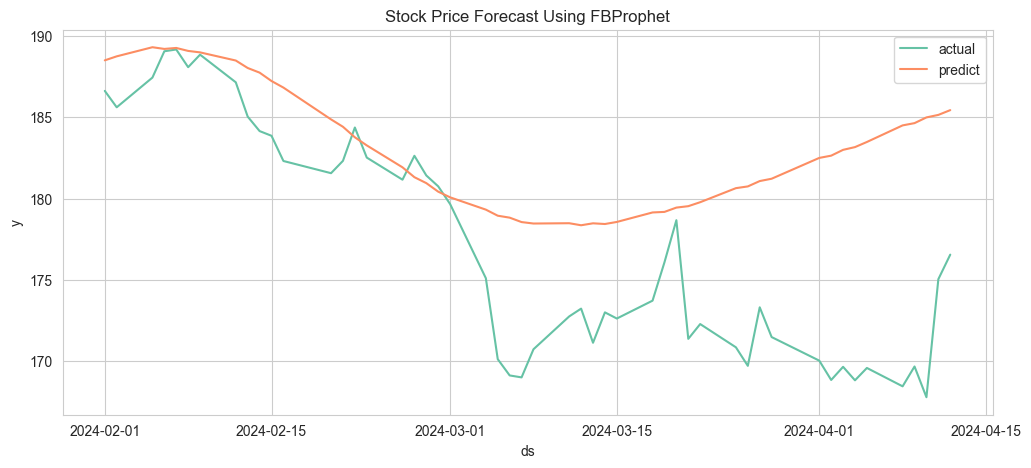

In [38]:
pred_dates = test.reset_index().rename(columns={"Date": "ds"})[["ds"]]
forecast = model.predict(pred_dates)

plt.figure(figsize=(12, 5))
sns.lineplot(label="actual", x=test['ds'], y=test['y'])
sns.lineplot(x=test['ds'], y=forecast["yhat"], label="predict")
plt.title("Stock Price Forecast Using FBProphet")
plt.legend()

In [39]:
print("RMSE:", RMSE(y_pred=y_pred['yhat'], y_true=test["y"]))
print("MAPE:", MAPE(y_pred=y_pred['yhat'], y_true=test["y"]))

RMSE: 15.750983219307304
MAPE: 0.0879084605449851


In [40]:
result["model"].append("FBProphet")
result["RMSE"].append(RMSE(y_pred=y_pred['yhat'], y_true=test["y"]))
result["MAPE"].append(MAPE(y_pred=y_pred['yhat'], y_true=test["y"]))

## Linear Regression

In [41]:
data = load_data(r"data\dataset\AAPL.csv")[["Adj Close"]]
train = create_shiftback_dataset(raw=data['Adj Close'], shift_back=5, end="2024-1-31")
test = create_shiftback_dataset(raw=data["Adj Close"], shift_back=5, start="2024-2-1")

RMSE: 2.263860051728316
MAPE: 0.009871475783051132


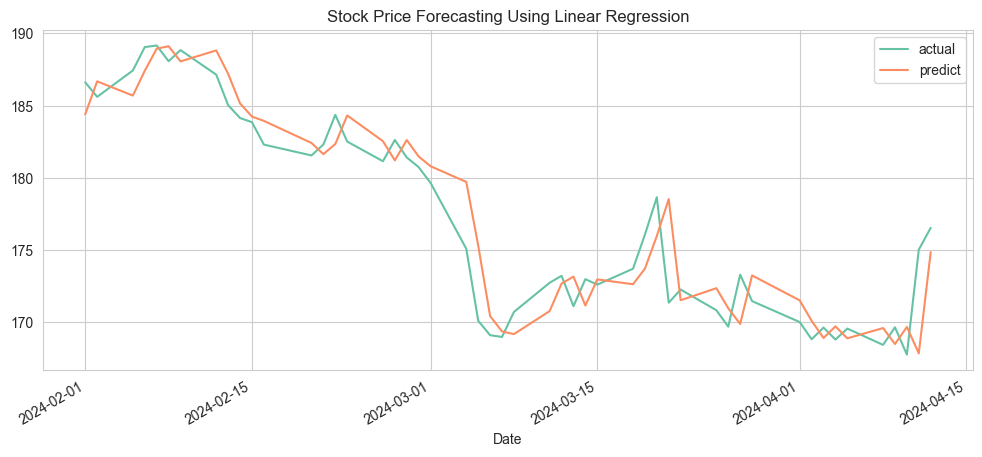

In [42]:
model = LinearRegression()
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting Using Linear Regression", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()

In [43]:
result["model"].append("LinearRegression")
result["RMSE"].append(RMSE(y_pred=y_pred, y_true=test["Target"]))
result["MAPE"].append(MAPE(y_pred=y_pred, y_true=test["Target"]))

## Random Forest

RMSE: 2.8272071769992793
MAPE: 0.012361017857978707


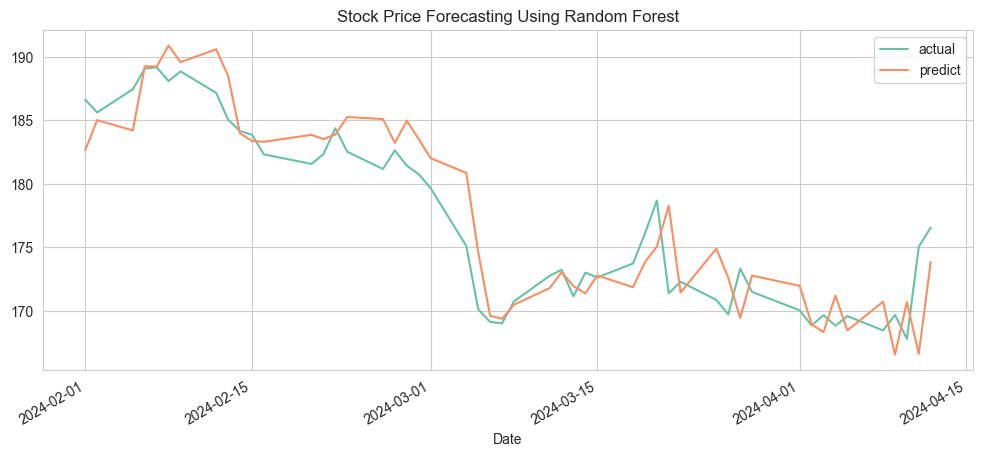

In [44]:
model = RandomForestRegressor(random_state=42)
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting Using Random Forest", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()

In [45]:
result["model"].append("RandomForest")
result["RMSE"].append(RMSE(y_pred=y_pred, y_true=test["Target"]))
result["MAPE"].append(MAPE(y_pred=y_pred, y_true=test["Target"]))

## XGBoost

RMSE: 2.6533387403924062
MAPE: 0.011393736136296396


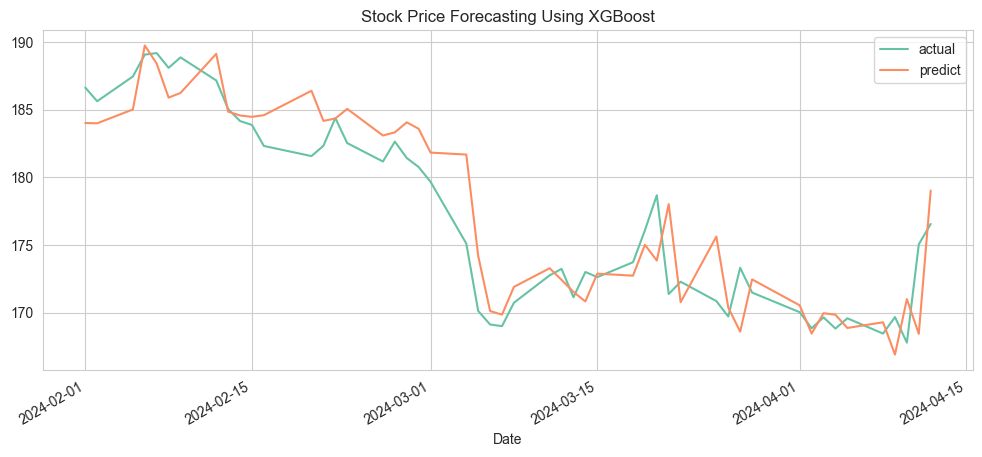

In [46]:
model = XGBRegressor(random_state=42)
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting Using XGBoost", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()

In [47]:
result["model"].append("XGBoost")
result["RMSE"].append(RMSE(y_pred=y_pred, y_true=test["Target"]))
result["MAPE"].append(MAPE(y_pred=y_pred, y_true=test["Target"]))

## KNN

RMSE: 2.895485607781693
MAPE: 0.013798931280799367


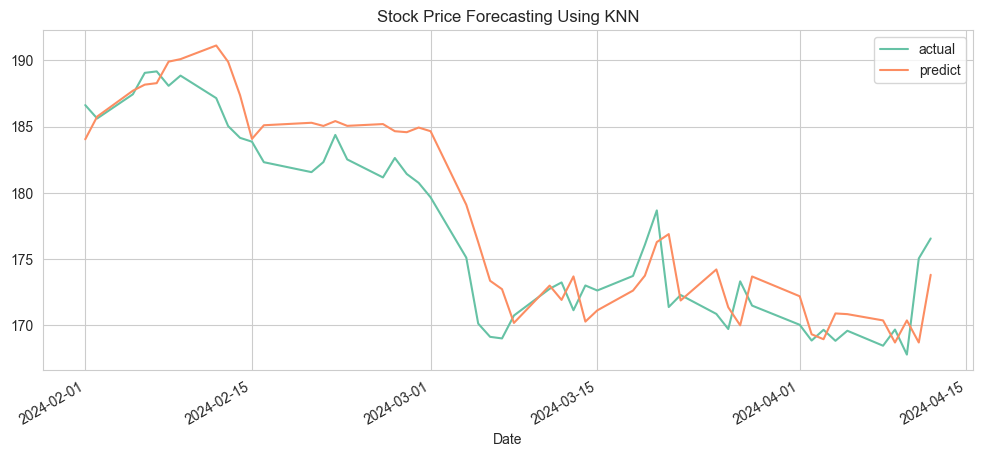

In [48]:
model = KNeighborsRegressor()
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting Using KNN", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()

In [49]:
result["model"].append("KNN")
result["RMSE"].append(RMSE(y_pred=y_pred, y_true=test["Target"]))
result["MAPE"].append(MAPE(y_pred=y_pred, y_true=test["Target"]))

## SVM Regressor

RMSE: 3.5317696680899964
MAPE: 0.016334010200559787


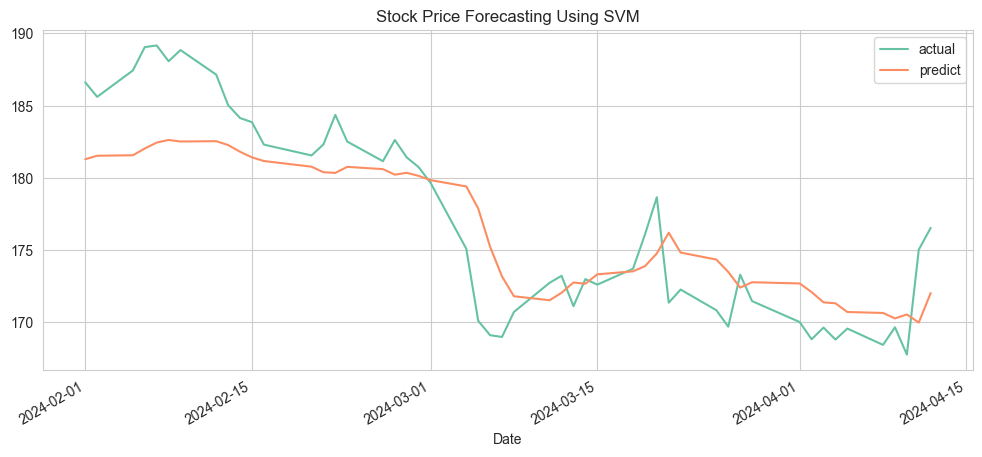

In [50]:
model = SVR()
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting Using SVM", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()

In [51]:
result["model"].append("SVM")
result["RMSE"].append(RMSE(y_pred=y_pred, y_true=test["Target"]))
result["MAPE"].append(MAPE(y_pred=y_pred, y_true=test["Target"]))

## LSTM

In [52]:
train = load_data(r"data\dataset\AAPL_train.csv")[["Adj Close"]]
test = load_data(r"data\dataset\AAPL_test.csv")[["Adj Close"]]
scaler = MinMaxScaler()
train[["Adj Close"]]= scaler.fit_transform(train[["Adj Close"]])
test[["Adj Close"]]= scaler.transform(test[["Adj Close"]])
data = pd.concat([train, test])

In [53]:
train = create_shiftback_dataset(raw=data['Adj Close'], shift_back=5, end="2024-1-31")
test = create_shiftback_dataset(raw=data["Adj Close"], shift_back=5, start="2024-2-1")

In [54]:
x_train = []
y_train = []
for i in range(train.shape[0]):
    x_train.append(train.iloc[i, :-1].values)
    y_train.append(train.iloc[i, -1])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(test.shape[0]):
    x_test.append(test.iloc[i, :-1].values)
    y_test.append(test.iloc[i, -1])
x_test = np.array(x_test)
y_test = np.array(y_test)

In [55]:
import tensorflow as tf
tf.random.set_seed(42)

# Build model - LSTM with 50 neurons and 4 hidden layers  
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(x_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.2942
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0575
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0212
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043
Epoch 13/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042
Epoch 14/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038
Epoch 15/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038

In [56]:
y_test = scaler.inverse_transform(test[["Target"]]).ravel()
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred).ravel()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 836ms/step


RMSE: 3.2885153766541846
MAPE: 0.01402603317846153


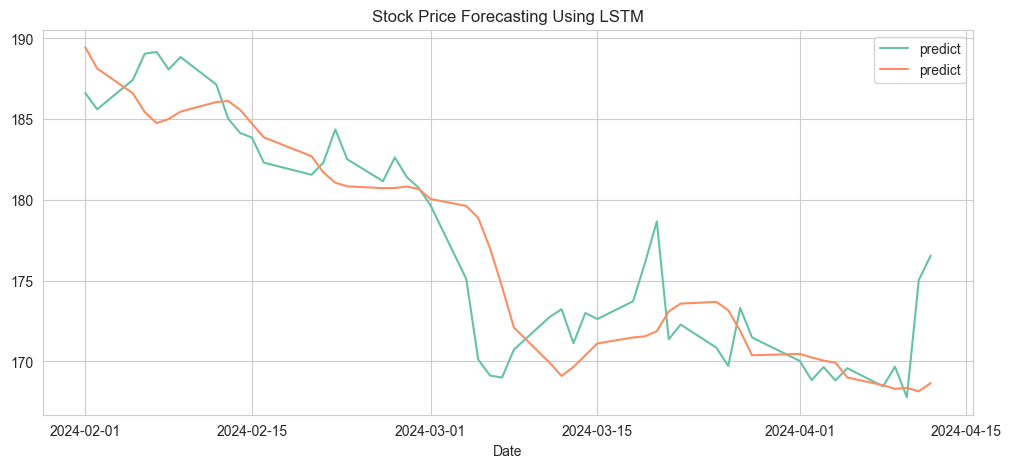

In [57]:
print("RMSE:", RMSE(y_pred=y_pred, y_true=y_test))
print("MAPE:", MAPE(y_pred=y_pred, y_true=y_test))

plt.figure(figsize=(12, 5))
sns.lineplot(x=test.index, y=y_test, label="predict")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.title("Stock Price Forecasting Using LSTM")
plt.legend()
plt.show()

In [58]:
result["model"].append("LSTM")
result["RMSE"].append(RMSE(y_pred=y_pred, y_true=y_test))
result["MAPE"].append(MAPE(y_pred=y_pred, y_true=y_test))

In [59]:
result_df = pd.DataFrame(result)
result_df = result_df.sort_values(by=["RMSE", "MAPE"], ascending=True, ignore_index=True)
# result_df.to_csv("output/models_evaluate.csv")

In [60]:
result_df

,model,RMSE,MAPE
0,ARIMA,2.247847,0.009657
1,LinearRegression,2.263860,0.009871
2,XGBoost,2.653339,0.011394
3,RandomForest,2.827207,0.012361
4,KNN,2.895486,0.013799
5,LSTM,3.288515,0.014026
6,SVM,3.531770,0.016334
7,FBProphet,15.750983,0.087908
